# Defect Thermodynamics

The theromodynamics of the defect creation is such that the current simulation conditionas are nowhere near a steady-state, with the temperatuee having an exponential rise. This is likely a result of the continued effects the removal of the moleucles has had on the cyrsatl structure. What I would like to investigate is whether theres is a set of conditions such that I no longer see this exponential rise in temperature.

In [1]:
# Import required modules
from sdrun import (
    initialise_snapshot,
    init_from_crystal,
    production,
    equilibrate,
    TrimerP2,
    SimulationParams as RunParams,
)
from sdanalysis.figures import configuration
from sdanalysis import HoomdFrame

import numpy as np
import pandas
from hoomd.data import make_snapshot
import hoomd
import altair as alt

import sys
sys.path.append("../src")
import figures

figures.use_my_theme()

from defects import (
    remove_molecule,
    remove_vertical,
    remove_horizontal,
    plot_snapshots,
    plot_snapshot,
)


from bokeh.plotting import show, output_notebook
from bokeh.layouts import gridplot

output_notebook()

Loading BokehJS ...

In [2]:
run_params = RunParams(
    init_temp=0.3,
    temperature=0.3,
    pressure=1.00,
    crystal=TrimerP2(),
    num_steps=40_000,
    cell_dimensions=(30, 42, 1),
    hoomd_args='--notice-level=0',
    outfile="defect.gsd"
)

## Initialise the Crystal Structure

This initialisation ensures that the crystal structure is equilibrted at the temperature defined in the `run_params` class, which is currently 0.3. I then remove 21 molecules which is half the unit cell and the most molecules removed in the [defect creation](06_Defect_Creation.ipynb).

In [3]:
# Create a crystal structure
with run_params.temp_context(init_temp=0.1):
    init_snapshot = equilibrate(
        init_from_crystal(run_params), run_params, equil_type="crystal"
    )
vert_snapshot = remove_vertical(init_snapshot, run_params, 21)

In [4]:
show(plot_snapshot(vert_snapshot))

The created initial configuration for the simulations, showing the absence of the particles which have been removed from teh simulation.

## Thermal Equilibration

The point of these simulations is establishing where the thermal equilibrium is of these simulations. Since there is a signiificant perturbation in the removal of a large number of particles, how long does it take the thermostats to readjust? Running a simulation at standard conditions, with a *tau* and *tauP* of 1 (*tau* is the imaginary mass of the thermostat, *tauP* for the barostat) and for 100 000 steps, which is on the order of magnitude of the structural relaxation time at this temperature.

In [5]:
with run_params.temp_context(tau=1, tauP=1, num_steps=1_000_000, output_interval=10_000, temperature=0.40):
    vert_snapshot0 = equilibrate(vert_snapshot, run_params, "crystal")

No random seed provided using 42


The thermodynamic quantities are output to a file equil-\*.log, where \* is a representation of the simulation conditions. This file is appended to, so to get the results of the last simulation we can find the last unique value. Note that this will still return resutls for previous simulations if the previous simulations have results for timescales longer than the current simulation.

In [6]:
thermo = pandas.read_csv("./equil-Trimer-P1.00-T0.40.log", sep='\t')
thermo.drop_duplicates('timestep', keep="last", inplace=True)

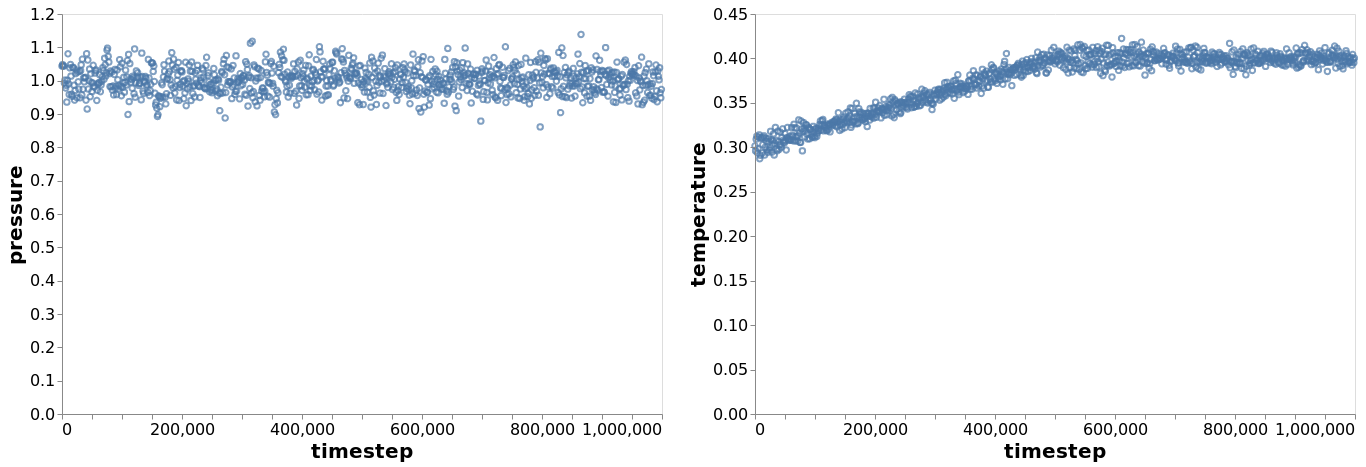

In [7]:
c = alt.Chart(thermo).mark_point().encode(
    x='timestep',
) 
c.encode(y='pressure') | c.encode(y="temperature")

Plotting the pressure and the temperature, we can see that both thermodynamic quantities remain rather stable throughout the entire simulation. The removal of the particles does cause some larger than normal fluctuations in the temperature, which are mostly quelled by ~20 000 timesteps, although there does seem to be generally larger fluctuations until ~45 000 timesteps.

In [8]:
show(plot_snapshot(vert_snapshot0))

After the 100 000 timesteps of simulation the configuration looks like the above figure. The bulk of the crystal is as the initial configuration, though there has been some changes around the defect. The main point of this figure is that the configuration appears to be relatively stable, which supports the thermodynamic data.